In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns
sns.set_style("dark")

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as EM

# Dim reduction
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from scipy.stats import kurtosis 

# Models
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_digits
from utils import learning_curve_plotter, model_param_curve, metrics

In [3]:
seed = 777

In [7]:
# Diabet Load Dataset

diabet_path = "./data/diabetes.csv"
df_diabet = pd.read_csv(diabet_path)

target = 'Outcome'
features = [ 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

X_origin, y = df_diabet[features], df_diabet[target]

# data normalize
sc = MinMaxScaler()
sc.fit(X_origin)

X = sc.transform(X_origin)
X_df = pd.DataFrame(X)
df_diabet = pd.concat([X_df, y], axis=1)

In [25]:
# Load Dataset

mnist = load_digits()

# fig, axes = plt.subplots(2, 10, figsize=(16, 6))
# for i in range(20):
#     axes[i//10, i %10].imshow(mnist.images[i], cmap='gray');
#     axes[i//10, i %10].axis('off')
#     axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")
    
# plt.tight_layout()

# data normalize
sc = MinMaxScaler()
sc.fit(mnist.data)

X = sc.transform(mnist.data)
X_df = pd.DataFrame(X)
y_target = pd.DataFrame(mnist.target)
df_digit = pd.concat([X_df, y_target], axis=1)

# Clustering

## K-means Clustering

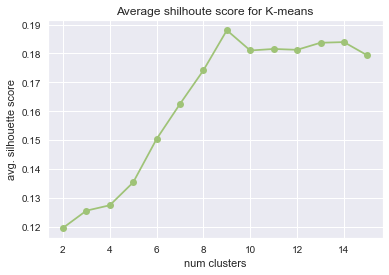

In [26]:
"""
https://m.blog.naver.com/slykid/221850725829
https://nicola-ml.tistory.com/6

shilhoutte analysis
각 군집 간의 거리가 얼마나 효율적으로 분리되어 있는지
-1~1사이의 값을 가지며 1에 가까울수록 좋다.
값이 높으면 객체가 자체 클러스터와 잘 일치, 클러스터와 잘 일치하지 않음.
"""

num_k = 15

def kmeans(df, num_k=15):
    sil_scores = []
    for k in range(2, num_k+1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=seed).fit(df.iloc[:,:-1])
        sil_score = silhouette_score(df.iloc[:,:-1], kmeans.labels_)
        sil_scores.append(sil_score)
    
    return sil_scores

def silhouette_plotter(sil_scores, num_k, title_name=None):
    plt.title(title_name)
    plt.xlabel("num clusters")
    plt.ylabel("avg. silhouette score")
    plt.grid()
    plt.plot(list(range(2, num_k+1)), sil_scores, "-o", color="C1")
    plt.show()
    plt.close()

# diabet_sil_scores = kmeans(df_diabet)
digit_sil_scores = kmeans(df_digit)

# silhouette_plotter(diabet_sil_scores, num_k, title_name="Average shilhoute score for K-means")
silhouette_plotter(digit_sil_scores, num_k, title_name="Average shilhoute score for K-means")

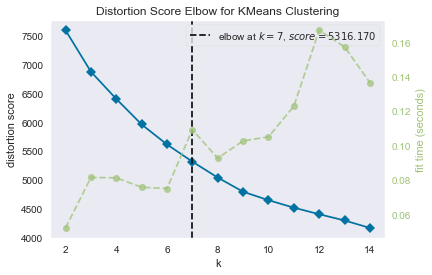

In [28]:
# 결과는 다음과 같이 나왔는데, 파란색이 각 데이터들의 군집 중심과의 평균 거리
# 초록색은 학습 시간을 나타낸다고 합니다.
# 검정색 점선의 위치를 보았을 떄, 여기서는 k = 4인 경우를 추천해주는 듯 합니다.
# 절대적인 정답이 있는 것은 아니니, 하나의 평가 지표로 활용하시면 좋을 듯 합니다.

def elbow_plotter(df_x, num_k):
    kmeans = KMeans()
    visualizer = KElbowVisualizer(kmeans, k=(2,num_k))
    visualizer.fit(df_x)
    visualizer.show()
    
# elbow_plotter(df_diabet.iloc[:,:-1], num_k)
elbow_plotter(df_digit.iloc[:,:-1], num_k)

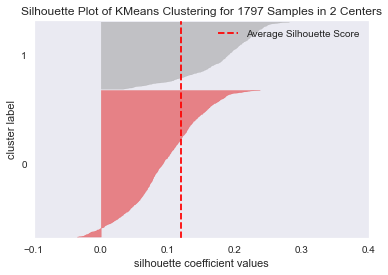

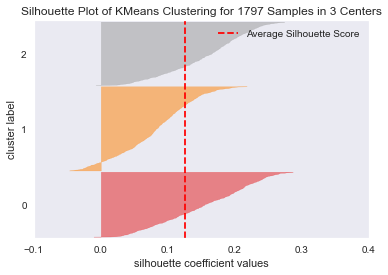

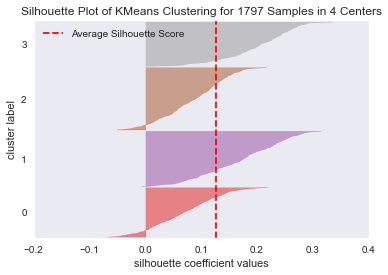

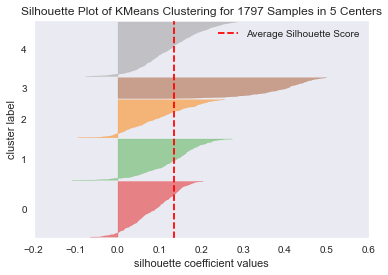

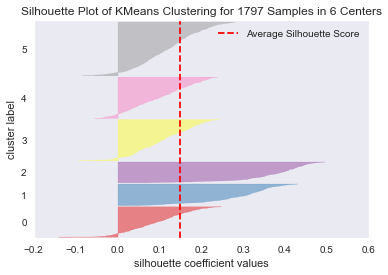

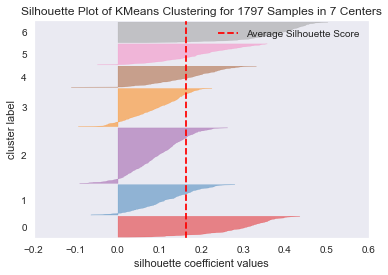

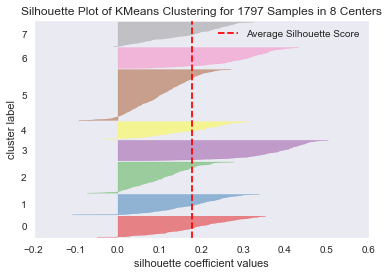

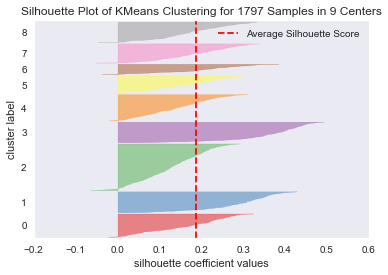

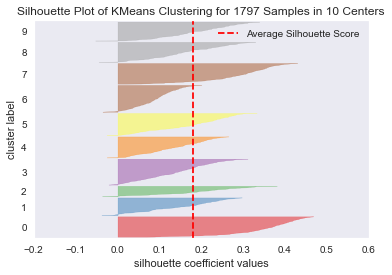

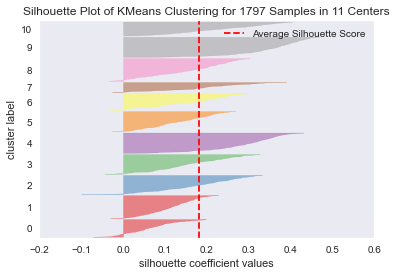

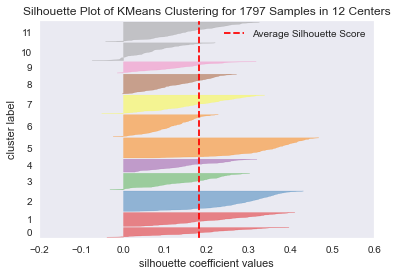

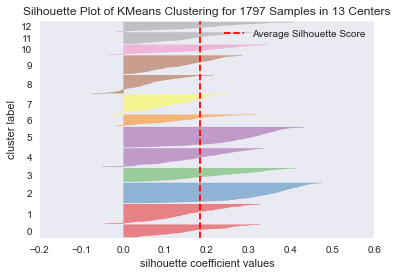

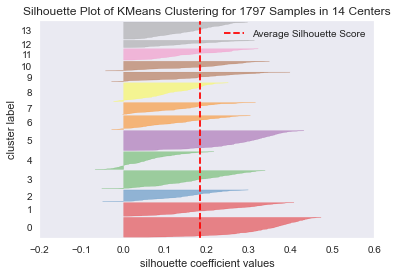

In [36]:
for i in range(2,15):
    kmeans = KMeans(i)
    vis = SilhouetteVisualizer(kmeans)
    vis.fit(df_digit.iloc[:,:-1])
    vis.finalize()
    plt.show()
    plt.close()

In [43]:
def knn_clustering_scores(optimal_k, df):
    kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=seed).fit(df.iloc[:,:-1])
    prediction = kmeans.predict(df.iloc[:,:-1])
    cluster_df = pd.DataFrame()
    cluster_df["kmeans_cluster"] = prediction
    cluster_df["target"] = df.iloc[:,-1]
    cluster_result = cluster_df.groupby(["target"])["kmeans_cluster"].value_counts()
    return cluster_df, cluster_result

# digit_cluster, digit_result = knn_clustering_scores(12,df_digit)
# diabet_cluster, diabet_result = knn_clustering_scores(6, df_diabet)

## EM algorithm

- 가우시안 분포: 도수 분포 곡선이 평균값을 중심으로 좌우 대칭
- GMM (Gaussian Mixture Model): 군집화에 대한 데이터가 여러개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정
- GMM에서 모수추정을 위해 2가지 추정방법: 개별 정규 분포의 평균과 분산 / 각 데이터가 어떤 정규 분포에 해당하는지의 확률

In [53]:
def em(df, num_k=15):
    sil_scores, aic_scores, bic_scores = [], [], []
    
    for k in range(2, num_k+1):        
        em = EM(n_components=k, warm_start=True, random_state=seed).fit(df.iloc[:,:-1])
        pred = em.predict(df.iloc[:,:-1])
        sil_score = silhouette_score(df.iloc[:,:-1], pred)
        sil_scores.append(sil_score)
        aic_scores.append(em.aic(df.iloc[:,:-1]))
        bic_scores.append(em.bic(df.iloc[:,:-1]))
        
    return sil_scores, aic_scores, bic_scores

def plotter(scores, num_k, title_name=None, color=None):
    plt.title(title_name)
    plt.xlabel("num clusters")
#     plt.ylabel("avg. silhouette score")
    plt.grid()
    plt.plot(list(range(2, num_k+1)), scores, "-o", color=color)
    plt.show()
    plt.close()

def em_clustering_scores(optimal_k, df):
    em = EM(n_components=optimal_k, n_init=10, random_state=seed).fit(df.iloc[:,:-1])
    prediction = em.predict(df.iloc[:,:-1])
    cluster_df = pd.DataFrame()
    cluster_df["em_cluster"] = prediction
    cluster_df["target"] = df.iloc[:,-1]
    cluster_result = cluster_df.groupby(["target"])["em_cluster"].value_counts()
    return cluster_df, cluster_result


diabet_scores = em(df_diabet)
digit_scores = em(df_digit)

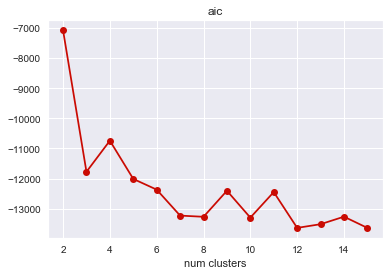

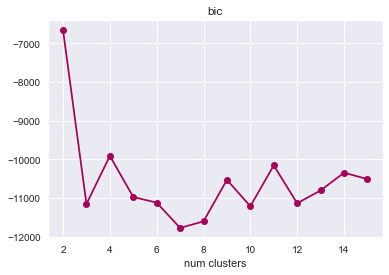

In [55]:
# Plotting
plotter(diabet_scores[0], num_k, title_name="silhouette", color="C1")
plotter(diabet_scores[1], num_k, title_name="aic", color="C2")
plotter(diabet_scores[2], num_k, title_name="bic", color="C3")

plotter(digit_scores[0], num_k, title_name="silhouette", color="C1")
plotter(digit_scores[1], num_k, title_name="aic", color="C2")
plotter(digit_scores[2], num_k, title_name="bic", color="C3")

In [62]:
# diabet_cluster, diabet_result = em_clustering_scores(12, df_diabet)
digit_cluster, digit_result = em_clustering_scores(12,df_digit)

print(digit_result)

target  em_cluster
0       0             177
        5               1
1       10            107
        2              34
        7              25
        4              13
        3               2
        8               1
2       7             154
        2              14
        11              4
        4               3
        0               1
        6               1
3       11            150
        2              16
        8               6
        4               5
        6               3
        9               2
        1               1
4       5             165
        1               7
        10              5
        6               4
5       9              97
        8              74
        4               9
        3               1
        5               1
6       3             176
        10              2
        0               1
        2               1
        9               1
7       1             114
        6              65
8       2          

In [17]:
sil_scores = []
aic_scores = []
bic_scores = []

for k in range(2, num_k+1):
    em = EM(n_components=k, warm_start=True, random_state=seed).fit(df_diabet.iloc[:,:-1])
    pred = em.predict(df_diabet.iloc[:,:-1])
    sil_score = silhouette_score(df_diabet.iloc[:,:-1], pred)
    sil_scores.append(sil_score)
    aic_scores.append(em.aic(df_diabet.iloc[:,:-1]))
    bic_scores.append(em.bic(df_diabet.iloc[:,:-1]))
    
#     return sil_score, aic_scores, bic_scores

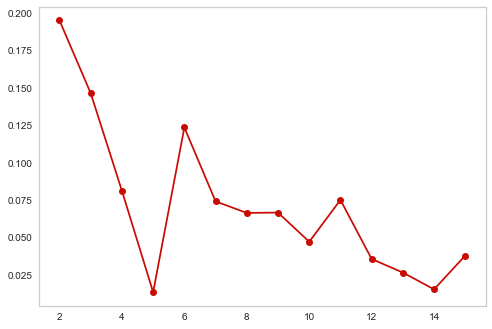

In [19]:
plt.plot(list(range(2, num_k+1)), sil_scores, "-o", color="C2")
# plt.plot(list(range(2, num_k+1)), aic_scores, "-o", color="C5")
# plt.plot(list(range(2, num_k+1)), bic_scores, "-o", color="C7")
plt.grid()
plt.show()